---
# Vision Transformer : comment un transformer peut-il apprendre à voir ?
---

**Introduction**

L'idée de cette démo est de coder son propre petit Vision Transformer brut. Dans une première partie, nous coderons les blocs constitutifs du ViT selon l'article originel. Puis, nous essaierons d'améliorer la robustesse de ses prédictions en appliquant deux méthodes différentes de distillation d'un CNN (resnet). Tout au long du notebook, nous afficherons les cartes d'attention pour mieux comprendre ce que le modèle a regardé pour faire sa prédiction.

In [ ]:
# True = On télécharge tes poids sauvegardés 
# False = L'utilisateur lance les entraînements
DEMO_MODE = True 

MODEL_URLS = {
    "vit_baseline": "https://github.com/adrienmanciet-sys/Vision_Transformers/raw/refs/heads/main/vit_baseline.pth",
    "vit_distilled2": "https://github.com/adrienmanciet-sys/Vision_Transformers/raw/refs/heads/main/vit_distilled2.pth",
    "deit2": "https://github.com/adrienmanciet-sys/Vision_Transformers/raw/refs/heads/main/deit2.pth"
}

import os
import torch
import wget 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_modele_pro(model, key_name):
    if DEMO_MODE:
        url = MODEL_URLS.get(key_name)
        filename = f"{key_name}.pth"
        
        if not os.path.exists(filename):
            print(f"Téléchargement de {key_name}...")
            wget.download(url, filename)
        
        # Chargement sécurisé
        state_dict = torch.load(filename, map_location=device)
        
        # --- TEST DE DIMENSIONS ---
        model_dict = model.state_dict()
        for k, v in state_dict.items():
            if k in model_dict:
                if v.shape != model_dict[k].shape:
                    print(f"ERREUR DIMENSION sur la couche : {k}")
                    print(f"   -> Dans le fichier .pth : {v.shape}")
                    print(f"   -> Dans ton code actuel : {model_dict[k].shape}")
        
        try:
            model.load_state_dict(state_dict, strict=False)
            print(f"Chargement réussi pour {key_name}")
        except Exception as e:
            print(f"Échec critique : {e}")
            
    return model.to(device)

---
## Préparation du modèle
---

### Extraction et préparation des images

**Choix du dataset**

Dans ce notebook, nous allons utiliser le dataset CIFAR10 de torchvision. Il a une résolution faible mais qui permet de faire tourner un petit modèle assez rapidement.

Importation de tous les modules importants :

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"using device: {device}")


Chargons les images à classifier :

In [ ]:
transform = transform = T.Compose([
    T.ToTensor(),
    # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = datasets.CIFAR10(root="./../data", download=True, transform=transform)

On affiche les classes extraites du dataset, et la manière dont on pourra récupérer le label de chaque image.

In [ ]:
classes = dataset.classes
image, label = dataset[12]
print(classes[label])

Affichons une image au hasard.

In [ ]:
image,label = dataset[12]
plt.imshow(image.permute(1,2,0).numpy())
plt.axis("off")
plt.show()

**Création des patchs**

On découpe l'image en patchs. Une première méthode consiste à parcourir la hauteur et la largeur de l'image.

In [ ]:
patch_size = 4
list_of_patches = []
for i in range(0, image.shape[1], patch_size):
    for j in range(0, image.shape[2], patch_size):
        patch = image[:,i:i+patch_size, j:j + patch_size]
        list_of_patches.append(patch)
tensor_patches = torch.stack(list_of_patches)
print(tensor_patches.shape)

Celle qui sera utilisée est un peu différente. Elle permet de faire la même chose plus rapidement.

In [ ]:
C,H,W = image.shape
# On utilise la fonction unfold pour découper l'image en patch contigus
# Le premier unfold découpe la première dimension (H) en ligne
# Le deuxième unfold découpe chacune des lignes en patch_size colonnes
# Ce qui donne une image de taille (C, H//patch_size, W//patch_size,patch_size, patch_size)
patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
# Permute pour avoir les dimensions dans le bon ordre
patches = patches.permute(1, 2, 0, 3, 4).contiguous()
patches = patches.view(-1, C, patch_size, patch_size)
print(patches.shape)
# On peut vérifier que ça fait bien la même chose
print((patches==tensor_patches).all())

In [ ]:
nb_patches = patches.shape[0]
print(nb_patches)
patches_flat = patches.flatten(1, 3)
print(patches_flat.shape)

On définit cette fonction qu'on réutilisera dans le passage d'une image dans le réseau.

In [ ]:
# La fonction a été modifiée pour prendre en compte le batch
def image_to_patches(image, patch_size):
    # On rajoute une dimension pour le batch
    B,C,_,_ = image.shape
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0,2, 3, 1, 4, 5).contiguous()
    patches = patches.view(B,-1, C, patch_size, patch_size)
    patches_flat = patches.flatten(2, 4)
    return patches_flat

### Création des différents blocs

Dans cette section, on va créer tous les blocs nécessaires pour faire le ViT selon le modèle de l'article.

**Couche d'attention simple**

On recrée une couhe d'attention unique selon le modèle présenté dans les slides.

In [ ]:
class Head_enc(nn.Module):
    """ Couche de self-attention unique """

    def __init__(self, head_size,n_embd,dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, return_attn = False):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Le * C**-0.5 correspond à la normalisation par la racine de head_size
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        attn_weights = wei
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        if return_attn:
            return out, attn_weights
        return out

**Couches d'attention multiple**

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head_enc(head_size, n_embd, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, return_attn=False):
        if return_attn:
            # On récupère (out, attn) pour chaque tête
            results = [h(x, return_attn=True) for h in self.heads]
            out = torch.cat([r[0] for r in results], dim=-1)
            # On fait la moyenne des matrices d'attention de toutes les têtes
            all_attn = torch.stack([r[1] for r in results]) # (num_heads, B, T, T)
            avg_attn = all_attn.mean(dim=0) # (B, T, T)
        else:
            out = torch.cat([h(x) for h in self.heads], dim=-1)

        out = self.dropout(self.proj(out))

        if return_attn:
            return out, avg_attn
        return out

**Perceptron multi-couches**

In [ ]:
class FeedFoward(nn.Module):

    def __init__(self, n_embd,dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

**Couche de transformer**

On assemble les blocs précédents.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embed, n_head, dropout=0.):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embed, dropout)
        self.ffwd = FeedFoward(n_embed, dropout)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x, return_attn=False):
        if return_attn:
            # On récupère l'attention de la couche de self-attention
            sa_out, attn = self.sa(self.ln1(x), return_attn=True)
            x = x + sa_out
            x = x + self.ffwd(self.ln2(x))
            return x, attn
        else:
            x = x + self.sa(self.ln1(x))
            x = x + self.ffwd(self.ln2(x))
            return x

---
## ViT Complet
---

On assemble les blocs précédents afin de constituer le ViT. Notez bien l'ajout du token de classe. C'est aussi dans le forward de cette classe que l'on applique la fonction permettant de générer des patchs à partir de l'image de départ.

Remarquez également qu'on extrait les schémas d'attentions à l'issu de chaque bloc. Seul le dernier schéma d'attention est retourné par la fonction car c'est celui utilisé pour faire la prédiction (c'est la ligne correspondant à l'attention du token de classe par rapport aux autres patchs qui est utilisée exactement).

Enfin, on utilise un dropout de $0.1$. Ce paramètre est un paramètre de régularisation du réseau. Concrètement, il retire 10% des poids de chaque couche entraînée, afin d'éviter que le réseau ne se base que sur quelques connexions pour sa prédiction. Cela permet d'éviter l'overfitting et donc d'améliorer la robustesse de l'algorithme aux données.

In [ ]:
class ViT_att(nn.Module):
    def __init__(self, n_embed, patch_size, C, n_head, n_layer, nb_patches, dropout=0.1):
        super().__init__()
        self.proj_layer = nn.Linear(C*patch_size*patch_size, n_embed)
        self.pos_emb = nn.Embedding(nb_patches+1, n_embed)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, n_embed))

        self.blocks = nn.ModuleList([TransformerBlock(n_embed, n_head, dropout) for _ in range(n_layer)])

        self.classi_head = nn.Linear(n_embed, 10)

    def forward(self, x, return_attn=False):
        B, _, _, _ = x.shape
        x = image_to_patches(x, patch_size)
        x = self.proj_layer(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        pos_emb = self.pos_emb(torch.arange(x.shape[1], device=x.device))
        x = x + pos_emb

        # On boucle sur les blocs
        all_attentions = []
        for block in self.blocks:
            if return_attn:
                x, attn = block(x, return_attn=True)
                all_attentions.append(attn)
            else:
                x = block(x)

        cls_token_final = x[:, 0]
        logits = self.classi_head(cls_token_final)

        if return_attn:
            # On renvoie les logits et l'attention du DERNIER bloc (le plus intéressant)
            return logits, all_attentions[-1]

        return logits

---
## Entraînement
---

**Chargement du dataset**

On commence par appliquer une symétrie aléatoire horizontale sur la moitié des images du dataset, puis une coupe aléatoire. Cela permet d'améliorer la robustesse de l'algorithme  des nouvelles données. C'est comme si on générait artificiellement des données.

In [ ]:
# --- Augmentation pour l'entraînement ---
train_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),    # pour l'augmentation de données
    T.RandomCrop(32, padding=4),      
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- Simple pour Validation et Test ---
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

On sépare le dataset en données d'entraînement, de validation et de test. Rien de spécial à ce niveau là.

In [ ]:
from torch.utils.data import Dataset, random_split, DataLoader

# 1. Charger le dataset complet sans transfo
full_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test_dataset_raw = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

# 2. Séparation Train / Val (à partir du set de train original de 50k images)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(full_dataset, [train_size, val_size])

# --- Classe Wrapper pour appliquer les transfos ---
class ApplyTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

# 3. Création des datasets finaux
train_set = ApplyTransform(train_indices, transform=train_transform)
val_set = ApplyTransform(val_indices, transform=test_transform)
test_set = ApplyTransform(test_dataset_raw, transform=test_transform)

# 4. DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Petit test d'affichage pour vérifier les dimensions
img, label = next(iter(train_loader))
print(f"Batch images shape : {img.shape}") # Attendu: [32, 3, 64, 64]
print(f"Batch labels shape : {label.shape}")

classes = full_dataset.classes
print(f"Classes détectées : {classes}")

**Entraînement**  

Le choix des paramètres du réseau et de l'entraînement est important :
- patch_size de 4 : c'est une taille propice aux images de 32 par 32
- n_embed de 64 : cela permet au réseau de ne pas contenir trop de paramètres tout en le dotant d'une capacité de représentation des patchs correcte.128 a également été testé mais donne des résultats moins concluant car la dimension est trop grande pour les informations à encoder par patch.
- n_head de 4 : chaque tête couvre 16 dimensions de l'embedding, ce qui est correct;
- n_layer de 4 : reprenons l'idée de l'article d'avoir à peu près autant de couches que de têtes d'attention
- 10 époques : permet un entraînement en environ 7min sur collab
- learning rate de $10^{-3}$ : bon compromis expérimenté en amont

Nous créons donc une instance de la classe ViT_att (Vision Transformer avec sauvegarde du dernier schéma d'attention).

In [ ]:
patch_size = 4
nb_patches = (32//patch_size)**2
n_embed = 64
n_head = 4
n_layer = 4
epochs = 10
C=3 # Nombre de canaux
lr = 1e-3
model_baseline = ViT_att(n_embed,patch_size,C,n_head,n_layer,nb_patches).to(device)
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=lr)

Affichons le nombre de paramètres du modèle.

In [ ]:
def count_parameters(model):
    # On ne compte que les paramètres qui nécessitent un gradient (ceux qui apprennent)
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Utilisation
num_params = count_parameters(model_baseline)
print(f"Nombre total de paramètres entraînables : {num_params:,}")

Voici l'entraînement à proprement parler. Sur colab, il faut compter environ 7 minutes. Si DEMO_MODE = True, on télécharge les poids du modèle pré-entraîné sur 20 époques.

In [ ]:
model_baseline=load_modele_pro(model_baseline, "vit_baseline")

if not DEMO_MODE:
    model = model_baseline
    for epoch in range(epochs):
        model.train()
        loss_train = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = F.cross_entropy(output, labels)
            loss_train += loss.item()
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        loss_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss_val += F.cross_entropy(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch}, loss train {loss_train/len(train_loader)}, loss val {loss_val/len(val_loader)},précision {100 * correct / total}")

On définit une fonction d'évaluation qui permet d'afficher la précision sur chacune des classes.

In [ ]:

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    # On initialise un dictionnaire pour voir la précision par classe
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    print(f"Évaluation de modèle en cours...")

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calcul par classe
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    accuracy = 100 * correct / total
    print(f"\nPrécision globale du modèle : {accuracy:.2f}%")
    print("-" * 30)

    # Affichage du détail par classe
    for i in range(10):
        if class_total[i] > 0:
            print(f'Précision pour {classes[i]} : {100 * class_correct[i] / class_total[i]:.2f}%')

    return accuracy

In [ ]:
evaluate_model(model_baseline, test_loader, device)

**Analyse de la précision**

La précision obtenue est autour de 68%. Le modèle a bel et bien appris puisqu'il est plus précis que l'aléatoire. Néanmoins, la précision n'est pas au niveau de celle obtenue dans l'article de Google. Gardons bien à l'esprit que notre modèle est bien plus petit, qu'il n'est pas entraîné aussi longtemps et surtout que le jeu de données est assez restreint en comparaison à ce qu'il faudrait pour qu'un transformer apprenne à voir.

---
## Visualisation de l'attention
---

L'idée ici est de visualiser les zones de l'image que le modèle a jugé les plus pertinentes pour faire sa prédiction. C'est tout l'intérêt des cartes d'attention obtenues grâce au mécanisme d'attention.

Voici un rappel de ce qu'il se passe pour récupérer et analyser les scores d'attention qui nous intéressent.

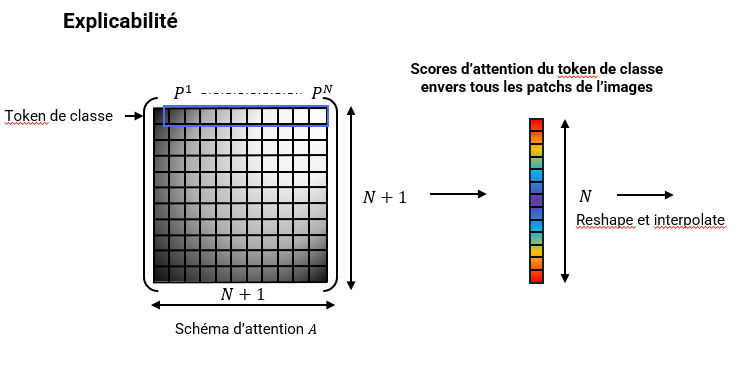

In [ ]:
def plot_attention(image,label, model, device):
    model.eval()
    with torch.no_grad():
        # 1. Obtenir la prédiction et l'attention (on ajoute une dimension batch)
        logits, attn = model(image.unsqueeze(0).to(device), return_attn=True)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        pred_label = torch.argmax(probs).item()

    # 2. Préparer l'attention (Moyenne des têtes, ligne du CLS, skip du CLS lui-même)
    mask = attn[0, 0, 1:].reshape(8, 8).cpu().numpy() # Pour une grille 4x4

    # 3. Affichage
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Image originale (on dé-normalise pour l'affichage)
    img_display = image.permute(1, 2, 0).cpu().numpy()
    img_display = (img_display * 0.5) + 0.5

    ax1.imshow(img_display)
    ax1.set_title(f"Pred: {classes[pred_label]} - Actual {classes[label]}")

    # Carte d'attention
    ax2.imshow(img_display) # On remet l'image en fond
    ax2.imshow(mask, cmap='jet', alpha=0.3, extent=(0, 32, 32, 0), interpolation='bilinear')
    ax2.set_title("Attention Map")
    plt.show()


Regardons ce que cela donne. Vous pouvez changer les variables pour afficher plus ou moins d'images, ainsi que sur des classes différentes.

In [ ]:
def plot(last_image_rank, class_to_print, model):
    # Test sur la première image du test_set
    for i in range(0,last_image_rank):
        sample_img, label = test_set[i]
        if classes[label]==class_to_print:
            plot_attention(sample_img, label, model, device)

In [ ]:
plot(50, 'dog', model=model_baseline)

**Conclusion**

Les zones regardées sont souvent cohérentes. Mais, le modèle a parfois tendance à utiliser des détails afin de déterminer la classe. Cela fonctionne dans certains cas, mais pas dans tous. C'est la limite de robustesse du modèle. Cependant, visualiser les cartes d'attention permet de nous en rendre compte.

On aimerait que le modèle regarde aux bons endroits. Pour prédire qu'une image est celle d'un chien, on voudrait qu'il regarde sa tête, pour une voiture ce pourrait être les roues et le pare-brise.

Dans la suite, nous allons essayer d'améliorer cet aspect.

---
## Distillation
---

On va appliquer le principe du 'Knowledge Distillation' afin de transférer les biais inductifs du CNN qui sera le professeur au ViT qui sera l'élève.

### Modèle Professeur

**Modèle pré-entraîné directement sur CIFAR10**

Pour cela, je choisis un modèle réputé être déjà bon sur CIFAR10.

In [ ]:
if not DEMO_MODE:
    teacher = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)
    teacher = teacher.to(device)
    teacher.eval() # Mode évaluation obligatoire pour la distillation

    # On fige les poids pour être sûr de ne pas consommer de mémoire inutilement
    for param in teacher.parameters():
        param.requires_grad = False

    print("Professeur (ResNet-18) chargé avec succès")

On vérifie qu'il est bien suffisamment précis pour être le professeur.

In [ ]:
if not DEMO_MODE:
    evaluate_model(teacher,test_loader, device)

In [ ]:
if not DEMO_MODE:
    def get_distillation_loss(student_logits, teacher_logits, labels, T=3.0, alpha=0.5):

        # Perte standard (Élève vs Labels réels)
        base_loss = F.cross_entropy(student_logits, labels)

        # Perte de Distillation (Élève vs Prof)
        # On utilise la divergence de Kullback-Leibler
        distill_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(student_logits / T, dim=-1),
            F.softmax(teacher_logits / T, dim=-1)
        ) * (T * T)

        return (1. - alpha) * base_loss + alpha * distill_loss

Comptez ici encore 7min d'entraînement.

In [ ]:
# On crée une nouvelle instance pour comparer proprement
model_distilled = ViT_att(n_embed, patch_size, C, n_head, n_layer, nb_patches).to(device) #décommenter pour réentraîner from scratch

model_distilled = load_modele_pro(model_distilled, "vit_distilled2")

if not DEMO_MODE:
    optimizer_distill = torch.optim.Adam(model_distilled.parameters(), lr=1e-3) # LR plus petit conseillé

    epochs_distill = 10

    for epoch in range(epochs_distill):
        model_distilled.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Le prof donne son avis
            with torch.no_grad():
                teacher_logits = teacher(images)

            # L'élève fait sa prédiction
            student_logits = model_distilled(images)

            # Calcul de la perte avec distillation
            loss = get_distillation_loss(student_logits, teacher_logits, labels, T=5.0, alpha=0.5)

            optimizer_distill.zero_grad()
            loss.backward()
            optimizer_distill.step()
            total_loss += loss.item()

        print(f"Epoch {epoch} terminée. Loss moyenne: {total_loss/len(train_loader):.4f}")

In [ ]:
evaluate_model(model_distilled, test_loader, device)

La précision reste globalement la même. Il reste à voir si les cartes d'attention témoignent ou non d'un changement dans la façon de voir les images.

In [ ]:
plot(50,'dog', model_distilled)

---
## Mise en place de la distillation Facebook - DeIT
---

On créée une architecture telle que celle proposée par l'article de Facebook, et détaillée ici.

<div style="display: flex; justify-content: center;">
  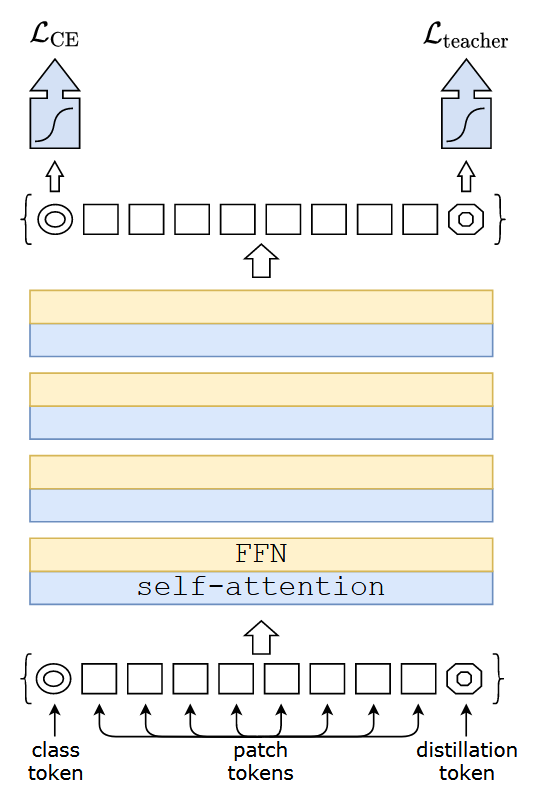
</div>

In [ ]:
class DeiT(nn.Module):
    def __init__(self, n_embed, patch_size, C, n_head, n_layer, nb_patches, dropout=0.1, n_classes=10):
        super().__init__()
        # 1. Projection et Embedding
        self.proj_layer = nn.Linear(C*patch_size*patch_size, n_embed)
        # +2 car on a maintenant le CLS token ET le Distill token
        self.pos_emb = nn.Embedding(nb_patches + 2, n_embed)

        # 2. Les deux tokens de Facebook
        self.cls_token = nn.Parameter(torch.zeros(1, 1, n_embed))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, n_embed))

        # 3. Ta pile de blocs personnalisés
        self.blocks = nn.ModuleList([TransformerBlock(n_embed, n_head, dropout) for _ in range(n_layer)])

        # 4. Les deux têtes de classification
        self.head_cls = nn.Linear(n_embed, n_classes)
        self.head_dist = nn.Linear(n_embed, n_classes)

    def forward(self, x, return_attn=False):
        B, _, _, _ = x.shape

        # Passage en patches (utilise ta fonction image_to_patches)
        x = image_to_patches(x, patch_size)
        x = self.proj_layer(x)

        # Ajout des deux tokens : [B, 1+1+nb_patches, n_embed]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        dist_tokens = self.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_tokens, x), dim=1)

        # Ajout des positions
        pos_indices = torch.arange(x.shape[1], device=x.device)
        x = x + self.pos_emb(pos_indices)

        # Passage dans les blocs Transformer
        all_attentions = []
        for block in self.blocks:
            if return_attn:
                x, attn = block(x, return_attn=True)
                all_attentions.append(attn)
            else:
                x = block(x)

        # Extraction des deux tokens finaux
        # Index 0 : Class Token | Index 1 : Distill Token
        cls_token_final = x[:, 0]
        dist_token_final = x[:, 1]

        logits_cls = self.head_cls(cls_token_final)
        logits_dist = self.head_dist(dist_token_final)

        if self.training:
            # En entraînement, on renvoie les deux pour les deux pertes
            return logits_cls, logits_dist

        # En évaluation / test
        if return_attn:
            # On renvoie la moyenne des prédictions et l'attention du dernier bloc
            return (logits_cls + logits_dist) / 2, all_attentions[-1]

        return (logits_cls + logits_dist) / 2

In [ ]:
patch_size = 4
nb_patches = (32//patch_size)**2
n_embed = 64
n_head = 4
n_layer = 4
epochs = 10
C=3 # Nombre de canaux
lr = 1e-3
model_deit = DeiT(n_classes=10, n_head=n_head, n_embed=n_embed, n_layer=n_layer, patch_size=patch_size, nb_patches=nb_patches, C=C).to(device)
optimizer = torch.optim.Adam(model_deit.parameters(), lr=lr)

In [ ]:
if not DEMO_MODE:
    def train_deit_hard(student, teacher, train_loader, optimizer, device, epochs=10):
        student.to(device)
        teacher.to(device)
        teacher.eval() # Le prof ne bouge pas

        # 1. Pour la vérité terrain (CLS) : On garde le smoothing pour éviter l'overfitting
        criterion_cls = nn.CrossEntropyLoss(label_smoothing=0.1)

        # 2. Pour le prof (DIST) : On veut une CrossEntropy PURE (Hard Distillation)
        # On veut copier exactement le choix "dur" du professeur, sans adoucissement.
        criterion_dist = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            student.train()
            total_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # --- PARTIE PROFESSEUR ---
                with torch.no_grad():
                    teacher_logits = teacher(images)
                    # Hard Label : Le prof tranche (c'est l'index max)
                    teacher_labels = teacher_logits.argmax(dim=1)

                # --- PARTIE ÉLÈVE ---
                # Forward : on récupère les deux têtes
                out_cls, out_dist = student(images)

                # --- CALCUL DES PERTES ---
                # Le CLS token apprend des vrais labels (avec doute raisonnable)
                loss_cls = criterion_cls(out_cls, labels)

                # Le Distill token apprend dogmatiquement du prof (sans doute)
                loss_dist = criterion_dist(out_dist, teacher_labels)

                # Moyenne des deux (Equation DeiT)
                loss = 0.5 * loss_cls + 0.5 * loss_dist

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

In [ ]:
deit = load_modele_pro(model_deit, "deit2")

if not DEMO_MODE:
    train_deit_hard(model_deit, teacher, train_loader, optimizer, device)

In [ ]:
evaluate_model(deit, test_loader, device)

In [ ]:
def plot_deit(last_image_rank, class_to_print, model, dataset, device):
    model.eval()
    model.to(device)

    for i in range(last_image_rank):
        img, label = dataset[i]

        if classes[label] == class_to_print:
            inputs = img.unsqueeze(0).to(device)

            with torch.no_grad():
                # On récupère les prédictions et l'attention du dernier bloc
                _, attn = model(inputs, return_attn=True)

            # 1. Vérification de la dimension de attn
            # attn doit être [batch, heads, tokens, tokens] -> ex: [1, 4, 66, 66]
            if attn.dim() == 4:
                # Moyenne sur les têtes (dim 1) et retrait du batch (dim 0)
                attn_map = attn.mean(dim=1).squeeze(0) # Résultat: [66, 66]
            else:
                attn_map = attn.squeeze() # Cas de secours

            # 2. Extraction sécurisée du masque
            # On veut la ligne 0 (le CLS) pour les colonnes 2 à fin (les patchs)
            # On s'assure de ne prendre que 64 éléments pour le reshape (8x8)
            cls_attention_on_patches = attn_map[0, 2:66]

            try:
                mask = cls_attention_on_patches.reshape(8, 8).cpu().numpy()
            except RuntimeError:
                print(f"Erreur de reshape: taille obtenue {cls_attention_on_patches.shape}")
                continue

            # 3. Affichage
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))

            # Dé-normalisation
            img_np = img.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np * 0.5) + 0.5

            ax[0].imshow(np.clip(img_np, 0, 1))
            ax[0].set_title(f"Original: {classes[label]}")
            ax[0].axis('off')

            # Heatmap
            ax[1].imshow(img_np)
            ax[1].imshow(mask, cmap='jet', alpha=0.4, extent=(0, 32, 32, 0), interpolation='bilinear')
            ax[1].set_title("CLS Attention (DeiT)")
            ax[1].axis('off')

            plt.show()
# Exemple d'utilisation :
plot_deit(last_image_rank=100, class_to_print='dog', model=deit, dataset=test_set, device=device)


---
## Comparaison finale des modèles
---

**Préparation de l'affichage des comparaisons**

In [ ]:
def compare_distillation_maps(image_tensor, label, model_vit, model_distill_soft, model_deit_fb, device, classes=None):
    models_info = {
        "ViT Classique": (model_vit, "cls"),
        "Distillation Soft": (model_distill_soft, "cls"),
        "DeiT Facebook": (model_deit_fb, "cls")
    }

    masks = {}
    pred_indices = {} # On stocke les indices (0, 1, 2...)

    # S'assurer que le label est un entier simple
    actual_idx = label.item() if isinstance(label, torch.Tensor) else int(label)

    for name, (model, mode) in models_info.items():
        model.eval().to(device)
        with torch.no_grad():
            logits, attn = model(image_tensor.unsqueeze(0).to(device), return_attn=True)

            # On stocke l'indice de la prédiction
            pred_indices[name] = torch.argmax(logits, dim=1).item()

            if attn.dim() == 4:
                attn = attn.mean(dim=1)

            if mode == "cls":
                mask_flat = attn[0, 0, -64:]
            else:
                mask_flat = attn[0, 1, -64:]

            grid_size = int(np.sqrt(mask_flat.shape[0]))
            masks[name] = mask_flat.reshape(grid_size, grid_size).cpu().numpy()

    vmax_global = max([m.max() for m in masks.values()])
    vmin_global = 0

    fig, axes = plt.subplots(1, 4, figsize=(22, 7))
    img_display = (image_tensor.permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5
    img_display = np.clip(img_display, 0, 1)

    # Label réel en texte
    actual_name = classes[actual_idx] if classes else f"Class {actual_idx}"
    axes[0].imshow(img_display)
    axes[0].set_title(f"ORIGINALE\nLabel: {actual_name}", fontsize=12, fontweight='bold')
    axes[0].axis('off')

    for i, (name, mask) in enumerate(masks.items(), 1):
        axes[i].imshow(img_display)
        im = axes[i].imshow(mask, cmap='jet', alpha=0.5, extent=(0, 32, 32, 0),
                           interpolation='bilinear', vmin=vmin_global, vmax=vmax_global)

        # Comparaison sur les INDICES (numéros)
        p_idx = pred_indices[name]
        is_correct = (p_idx == actual_idx)

        # Transformation en texte seulement pour l'affichage
        pred_name = classes[p_idx] if classes else f"Class {p_idx}"
        color = "green" if is_correct else "red"

        axes[i].set_title(f"{name.upper()}\nPred: {pred_name}\nMax Attn: {mask.max():.3f}",
                          fontsize=11, color=color)
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [ ]:
model_vit = model_baseline
model_distilled_soft = model_distilled
model_deit_fb = model_deit
for i in range(300,400):
    image, label = test_set[i]
    if classes[label]=='horse':
        compare_distillation_maps(image, label, model_vit, model_distilled_soft, model_deit_fb, device=device, classes=classes)


---
# Conclusion
---

Au terme de cette étude comparative sur le dataset CIFAR-10, nous avons mis en lumière les capacités et les limites des architectures Transformers face à la distillation de connaissances. Voici le bilan de nos expérimentations :

**1. La Robustesse du ViT Baseline**

L'architecture Vision Transformer (ViT) standard parvient à une précision honorable d'environ 69% en seulement 20 époques. Plus surprenant encore, ses cartes d'attention sont les plus cohérentes visuellement : le modèle parvient à isoler des zones discriminantes, focalisant son énergie sur des parties spécifiques de l'objet.

**2. Le Paradoxe de la Distillation**

L'introduction des techniques de distillation n'a pas produit le saut de performance escompté :

- Précision stagnante : L'accuracy reste sensiblement la même que celle de la baseline (~68-69%).

- Attention diffuse : Au lieu de raffiner la focalisation, la distillation a rendu les cartes d'attention plus "étalées" et moins contrastées.

**3. Pourquoi une attention moins précise avec le CNN ?**

Alors que nous espérions que le CNN (ResNet) guiderait l'attention du Transformer vers des détails biologiques ou structurels (yeux, roues, ailes), nous avons observé l'inverse. Plusieurs pistes peuvent expliquer ce phénomène :

- Conflit de Biais Inductifs : Le CNN possède une vision locale et texturale. En forçant le Transformer à copier le CNN, on perturbe peut-être sa capacité naturelle à créer des relations globales, créant une attention "entre-deux" qui cherche des motifs partout où le CNN en voit, rendant le résultat final plus flou.
- La résolution CIFAR-10 : Sur des images de 32x32, le "champ de vision" du CNN couvre presque toute l'image très rapidement. La distillation transmet alors une importance répartie sur l'ensemble de l'objet plutôt qu'une focalisation chirurgicale.

**4. Perspectives et Limites**

Il est crucial de garder à l'esprit que ces résultats s'inscrivent dans un cadre restreint :
- Volume de données : Les Transformers sont gourmands. Avec seulement 50 000 images, le modèle n'a pas l'occasion de montrer la supériorité de la distillation qui s'exprime normalement sur des millions d'exemples.
- Temps d'entraînement : 20 époques constituent une preuve de concept. Dans la littérature scientifique (Facebook/DeiT), ces modèles sont entraînés sur 300 époques pour permettre à l'attention de se stabiliser et de se spécialiser.

En conclusion, si la distillation n'a pas transformé nos scores ici, elle illustre parfaitement la complexité du transfert de connaissances entre deux architectures aux philosophies opposées (local vs global).